## Dataset va muammo

Ushbu kod bilan **Fashion-MNIST** datasetidan foydalanamiz.  
Dataset 28×28 o‘lchamdagi kiyim rasmlaridan iborat.

### Muammo
Biz **binary classification** muammosini ko‘rib chiqamiz:

- **1** → Ankle boot (etik)
- **0** → Boshqa barcha kiyim turlari

### Maqsad
Bu yerda maqsad eng kuchli model qurish emas.  
Asosiy e’tibor:
- Machine Learning pipeline qanday ishlashiga
- Baholash (metrics) qanday alday olishini ko‘rishga
- Data leakage va class imbalance muammolarini tushunishga

Model soddaroq bo‘ladi, lekin xulosalar **real tizimlar uchun juda muhim**.


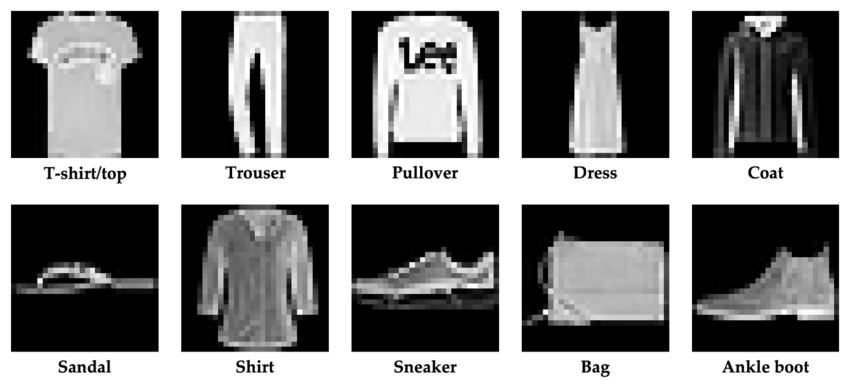

In [10]:
# 2-sessiya (rasm namunasi) — Fashion-MNIST logistic-demo
# Maqsad: rasm ma'lumotlaridan foydalangan holda o'qish, chalg'ituvchi ko'rsatkichlar, chegaraviy murosalarni ko'rsatish
# Purpose: show leakage, misleading metrics, threshold tradeoffs using image data
# pip install torch torchvision scikit-learn matplotlib

import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# ---------------------------
# 1) Load Fashion-MNIST and build a binary problem
# ---------------------------
# We'll classify "Ankle boot" (label 9) vs rest -> binary problem with natural imbalance.
transform = transforms.Compose([transforms.ToTensor()])
dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

X = np.stack([np.array(dataset[i][0]).squeeze() for i in range(len(dataset))])  # shape (60000,28,28)
y_full = np.array([dataset[i][1] for i in range(len(dataset))])

# make binary: target_class = 9 (Ankle boot)
target_class = 9
y = (y_full == target_class).astype(int)  # 1 = ankle boot, 0 = other

# get 4k samples for faster demo
idxs = np.random.choice(len(X), size=4000, replace=False)
X = X[idxs]
y = y[idxs]

# flatten images
n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1).astype(np.float32)

print("Total samples:", X_flat.shape)



100%|██████████| 26421880/26421880 [00:04<00:00, 6482160.24it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1355957.84it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 8022332.22it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16041810.54it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Total samples: (4000, 784)


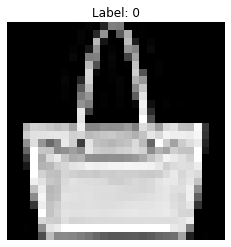

In [12]:
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

In [13]:
def train_eval(X_tr, y_tr, X_te, y_te, desc="pipeline"):
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    
    clf = LogisticRegression(max_iter=2000, solver='saga')
    clf.fit(X_tr_s, y_tr)

    probs = clf.predict_proba(X_te_s)[:,1]

    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_te, preds)
    prec = precision_score(y_te, preds, zero_division=0)
    rec = recall_score(y_te, preds, zero_division=0)
    try:
        auc = roc_auc_score(y_te, probs)
    except:
        auc = float('nan')
    cm = confusion_matrix(y_te, preds)
    print(f"--- {desc} ---")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  AUC: {auc:.4f}")
    print("Confusion matrix:\n", cm)
    return {'acc':acc, 'prec':prec, 'rec':rec, 'auc':auc, 'probs':probs, 'preds':preds, 'clf':clf}


In [14]:
# ---------------------------
# 2) Baseline (correct pipeline)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.25, random_state=42, stratify=y
)

res_baseline = train_eval(X_train, y_train, X_test, y_test, desc="Baseline (no leakage)")


--- Baseline (no leakage) ---
Accuracy: 0.9750  Precision: 0.8774  Recall: 0.8857  AUC: 0.9886
Confusion matrix:
 [[882  13]
 [ 12  93]]


In [15]:
# ---------------------------
# 3) Leakage misoli A: bo'lishdan oldin (yomon) BUTUN ma'lumotlar bilan masshtablash (moslashtiruvchi)
# ---------------------------
scaler_all = StandardScaler().fit(X_flat)   # LEAKAGE: test stats ishlatilmoqda!
X_scaled_all = scaler_all.transform(X_flat)

Xtr_leakA, Xte_leakA, ytr_leakA, yte_leakA = train_test_split(
    X_scaled_all, y, test_size=0.25, random_state=42, stratify=y
)
clf_leakA = LogisticRegression(max_iter=2000, solver='saga')
clf_leakA.fit(Xtr_leakA, ytr_leakA)
probs_leakA = clf_leakA.predict_proba(Xte_leakA)[:,1]
preds_leakA = (probs_leakA >= 0.5).astype(int)

print("\n--- Leakage A: bo'lishdan oldin (yomon) BUTUN ma'lumotlar bilan masshtablash (moslashtiruvchi) ---")
print(f"Accuracy (leaky): {accuracy_score(yte_leakA, preds_leakA):.4f}  AUC: {roc_auc_score(yte_leakA, probs_leakA):.4f}")
print("Confusion matrix (leaky):\n", confusion_matrix(yte_leakA, preds_leakA))



--- Leakage A: bo'lishdan oldin (yomon) BUTUN ma'lumotlar bilan masshtablash (moslashtiruvchi) ---
Accuracy (leaky): 0.9690  AUC: 0.9872
Confusion matrix (leaky):
 [[875  20]
 [ 11  94]]


In [16]:

# ---------------------------
# 4) Leakage example B: add a noisy label-derived feature (simulated severe leakage)
# ---------------------------
rng = np.random.RandomState(0)
leak_feature = y + 0.02 * rng.randn(len(y))  # almost equals label
X_with_leak = np.hstack([X_flat, leak_feature.reshape(-1,1)])

Xtr_leakB, Xte_leakB, ytr_leakB, yte_leakB = train_test_split(
    X_with_leak, y, test_size=0.25, random_state=42, stratify=y
)
res_leakB = train_eval(Xtr_leakB, ytr_leakB, Xte_leakB, yte_leakB, desc="Leakage B (label-derived feature)")


--- Leakage B (label-derived feature) ---
Accuracy: 0.9990  Precision: 0.9906  Recall: 1.0000  AUC: 0.9998
Confusion matrix:
 [[894   1]
 [  0 105]]


In [17]:
# ---------------------------
# 5) Misleading metric: sun'iy ravishda o'ta sinfiy nomutanosiblikni (class imbalance) yaratish
# ---------------------------
def make_imbalanced(X, y, pos_ratio=0.02, total_size=5000, random_state=0):
    """
    Create an imbalanced dataset with a given positive ratio and total size.
    """
    rng = np.random.RandomState(random_state)
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    n_pos = max(1, int(total_size * pos_ratio))
    n_neg = total_size - n_pos

    # safety checks
    n_pos = min(n_pos, len(pos_idx))
    n_neg = min(n_neg, len(neg_idx))

    pos_keep = rng.choice(pos_idx, size=n_pos, replace=False)
    neg_keep = rng.choice(neg_idx, size=n_neg, replace=False)

    keep = np.concatenate([pos_keep, neg_keep])
    rng.shuffle(keep)

    return X[keep], y[keep]


X_imbal, y_imbal = make_imbalanced(
    X_flat, y,
    pos_ratio=0.02,
    total_size=4000
)

Xtr_i, Xte_i, ytr_i, yte_i = train_test_split(X_imbal, y_imbal, test_size=0.25, random_state=42, stratify=y_imbal)
res_imbal = train_eval(Xtr_i, ytr_i, Xte_i, yte_i, desc="Imbalanced (pos ratio ~2%)")
print("Izoh: barcha salbiylarni bashorat qiladigan klassifikator bu yerda ham yuqori aniqlikka ega bo'lishi mumkin.")


--- Imbalanced (pos ratio ~2%) ---
Accuracy: 0.9923  Precision: 0.8421  Recall: 0.8000  AUC: 0.9940
Confusion matrix:
 [[892   3]
 [  4  16]]
Izoh: barcha salbiylarni bashorat qiladigan klassifikator bu yerda ham yuqori aniqlikka ega bo'lishi mumkin.



Threshold tradeoff (baseline classifier):
thr=0.20  acc=0.964  prec=0.776  rec=0.924
thr=0.30  acc=0.969  prec=0.819  rec=0.905
thr=0.40  acc=0.972  prec=0.841  rec=0.905
thr=0.50  acc=0.975  prec=0.877  rec=0.886
thr=0.60  acc=0.977  prec=0.894  rec=0.886
thr=0.70  acc=0.976  prec=0.893  rec=0.876


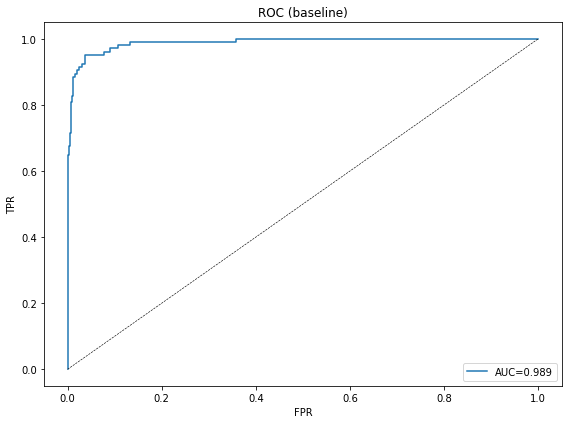

In [18]:
# ---------------------------
# 6) Threshold sensitivity demo (use baseline probs)
# ---------------------------
probs_baseline = res_baseline['probs']
y_true = y_test
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
print("\nThreshold tradeoff (baseline classifier):")
for t in thresholds:
    preds_t = (probs_baseline >= t).astype(int)
    print(f"thr={t:.2f}  acc={accuracy_score(y_true, preds_t):.3f}  prec={precision_score(y_true, preds_t, zero_division=0):.3f}  rec={recall_score(y_true, preds_t, zero_division=0):.3f}")

# ROC plot
fpr, tpr, _ = roc_curve(y_true, probs_baseline)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC={res_baseline['auc']:.3f}")
plt.plot([0,1],[0,1],'k--', linewidth=0.6)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (baseline)"); plt.legend()
plt.tight_layout()
plt.show()